In [67]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage,SystemMessage
from langchain_core.runnables import RunnableConfig
import json


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]


wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format='list')

tools = [search]

model = ChatOllama(model="qwen2.5:32b")
model = model.bind_tools(tools)

In [68]:
system_message = '''You are a Lab Assistant designed to assist with scientific experiments. Your task is to provide:

Experiment Materials: A list of required materials and equipment.
Experiment Steps: A detailed step-by-step guide for conducting the experiment.
Safety Procedures: Essential precautions to ensure a safe experiment.
Before generating the final response, you will:

Search the query using DuckDuckGo to gather up-to-date and relevant information.
Analyze the results to determine if the information is complete.
Enhance the response by integrating the best available knowledge before providing the final answer.which is not a summary but well explained'''

In [1]:
import requests
import json
import time
import sys
import base64
import os
from typing import Dict, Any
from pydantic import BaseModel,Field
from typing import Union


class Crawl4AiTester:
    def __init__(self, base_url: str = "http://192.168.23.138:11235", api_token: str = None):
        self.base_url = base_url
        self.api_token = (
            api_token or os.getenv("CRAWL4AI_API_TOKEN") or "test_api_code"
        )  # Check environment variable as fallback
        self.headers = (
            {"Authorization": f"Bearer {self.api_token}"} if self.api_token else {}
        )

    def submit_and_wait(
        self, request_data: Dict[str, Any], timeout: int = 300
    ) -> Dict[str, Any]:
        # Submit crawl job
        response = requests.post(
            f"{self.base_url}/crawl", json=request_data, headers=self.headers
        )
        if response.status_code == 403:
            raise Exception("API token is invalid or missing")
        task_id = response.json()["task_id"]
        print(f"Task ID: {task_id}")

        # Poll for result
        start_time = time.time()
        while True:
            if time.time() - start_time > timeout:
                raise TimeoutError(
                    f"Task {task_id} did not complete within {timeout} seconds"
                )

            result = requests.get(
                f"{self.base_url}/task/{task_id}", headers=self.headers
            )
            status = result.json()

            if status["status"] == "failed":
                print("Task failed:", status.get("error"))
                raise Exception(f"Task failed: {status.get('error')}")

            if status["status"] == "completed":
                return status

            time.sleep(2)

    def submit_sync(self, request_data: Dict[str, Any]) -> Dict[str, Any]:
        response = requests.post(
            f"{self.base_url}/crawl_sync",
            json=request_data,
            headers=self.headers,
            timeout=60,
        )
        if response.status_code == 408:
            raise TimeoutError("Task did not complete within server timeout")
        response.raise_for_status()
        return response.json()

    def crawl_direct(self, request_data: Dict[str, Any]) -> Dict[str, Any]:
        """Directly crawl without using task queue"""
        response = requests.post(
            f"{self.base_url}/crawl_direct", json=request_data, headers=self.headers
        )
        response.raise_for_status()
        return response.json()


def test_docker_deployment(version="basic"):
    tester = Crawl4AiTester(
        base_url="http://192.168.23.138:11235",
        # base_url="https://api.crawl4ai.com" # just for example
        # api_token="test" # just for example
    )
    print(f"Testing Crawl4AI Docker {version} version")

    # Health check with timeout and retry
    max_retries = 5
    for i in range(max_retries):
        try:
            health = requests.get(f"{tester.base_url}/health", timeout=10)
            print("Health check:", health.json())
            break
        except requests.exceptions.RequestException:
            if i == max_retries - 1:
                print(f"Failed to connect after {max_retries} attempts")
                sys.exit(1)
            print(f"Waiting for service to start (attempt {i+1}/{max_retries})...")
            time.sleep(5)

    # Test cases based on version
    # test_basic_crawl_direct(tester)
    # test_basic_crawl(tester)
    # test_basic_crawl(tester)
    # test_basic_crawl_sync(tester)

    # if version in ["full", "transformer"]:
    #     test_cosine_extraction(tester)

    # test_js_execution(tester)
    # test_css_selector(tester)
    # test_structured_extraction(tester)
    # test_llm_extraction(tester)
    test_llm_with_ollama(tester)
    




def test_llm_with_ollama(tester: Crawl4AiTester,url:str,schema:Union[dict,None]=None):
    # print("\n=== Testing LLM with Ollama ===")
    if schema is None:
        schema = {
            "type": "object",
            "properties": {
                "article_title": {
                    "type": "string",
                    "description": "The main title of the news article",
                },
                "summary": {
                    "type": "string",
                    "description": "A brief summary of the article content",
                },
                "main_topics": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "Main topics or themes discussed in the article",
                },
            },
        }

    request = {
        "urls": url,
        "priority": 8,
        "extraction_config": {
            "type": "llm",
            "params": {
                "provider": "qwen2.5:32b",
                "base_url":"http://192.168.23.138:11439",
                "schema": schema,
                "extraction_type": "schema",
                "instruction": "Extract the main article information including title, summary and if the article is about an experiment then extract materials, steps and safety procedures.",
            },
        },
        "extra": {"word_count_threshold": 1},
        "crawler_params": {"verbose": True},
    }

    try:
        result = tester.submit_and_wait(request)
        extracted = json.loads(result["result"]["extracted_content"])
        return extracted
        assert result["result"]["success"]
    except Exception as e:
        print(f"Ollama extraction test failed: {str(e)}")



In [2]:
test_docker_deployment()

Testing Crawl4AI Docker basic version
Health check: {'status': 'healthy', 'available_slots': 7, 'memory_usage': 21.3, 'cpu_usage': 2.4}


TypeError: test_llm_with_ollama() missing 1 required positional argument: 'url'

In [71]:
class crawlerSchema(BaseModel):
    title: str = Field(..., description="The title of the article")
    article: str = Field(..., description="rephrase the article so that it covers every part of the topic in a concise manner in about 500 words")
    # main_topics: str = Field(..., description="Main topics or themes discussed in the article")
    materials: str = Field( description="extract all the materials used in the experiment")
    steps: str = Field( description="exctract Step by step guide for conducting the experiment")
    safety_procedures: str = Field( description="Safety precautions for the experiment")


tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] == 'duckduckgo_results_json':
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            toSearch = [search['link'] for search in tool_result]
            print(toSearch)
            crawler_result = None
            pages_result = []
            for url in toSearch:
                # print(crawlerSchema.model_json_schema()['properties'])
                
                crawler_result = test_llm_with_ollama(tester=Crawl4AiTester(), url=url, schema=crawlerSchema.model_json_schema()['properties'])
                # if crawler_result.get('success', False):  # Assuming the result has a 'success' flag
                    # print(crawler_result)
                # print(crawler_result)
                pages_result.append(crawler_result)

            crawler_result = json.dumps({"search_results": pages_result})
            
            outputs.append(
                ToolMessage(
                    content=crawler_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
    return {"messages": outputs}
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        system_message
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

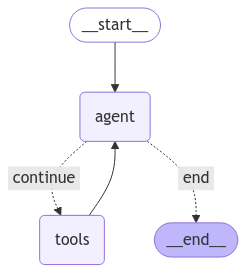

In [72]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [73]:
query = f"what should be the required materials and experiment procedure of the following lab Experiment (To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.)?"
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", query)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what should be the required materials and experiment procedure of the following lab Experiment (To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.)?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (920e4d4c-5e60-4280-a538-bcfd4d862689)
 Call ID: 920e4d4c-5e60-4280-a538-bcfd4d862689
  Args:
    query: materials and steps to measure input and output impedance of Op-Amp
['https://electronicmanufacturingservice.org/input-impedance-of-op-amp-what-it-is-and-how-to-calculate-it/', 'https://flexpcb.org/input-impedance-of-op-amp-what-it-is-and-how-to-calculate-it/', 'https://www.linkedin.com/pulse/input-impedance-op-amp-what-how-calculate-uraee', 'https://forum.allaboutcircuits.com/threads/output-resistance-measurment.204107/']
Task ID: 636969eb-30c8-4439-a32a-926656b09d8a
Task ID: 9ad27e87